In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#from google.colab import files
#uploaded = files.upload()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/My\ Drive/ECE-657A_project/Part-1

/content/drive/My Drive/ECE-657A_project/Part-1


In [0]:
# Reading, training and testing data
train = pd.read_csv('train.csv')
test = pd.read_csv('testX.csv')

# Remove Id and Label columns from the training data
train_x = train.drop(['Id', 'Label'], axis = 1)

# Take Label column as target variable
train_y = train['Label']

# Remove Id column from the test data
test = test.drop('Id', axis = 1)

# Spilt the data into 90% training and 10% validation data
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

# Transform the data
scalar = StandardScaler(with_std=False)
scalar.fit(X_train)
train_scaled = scalar.transform(X_train)
val_scaled = scalar.transform(X_val)
test_scaled = scalar.transform(test)

In [0]:
# PCA as a dimensionality reduction technique
pca = PCA()
pca.fit(train_scaled)
train_x_transformed  = pca.transform(train_scaled)
val_x_transformed = pca.transform(val_scaled)
test_transformed = pca.transform(test_scaled)

Variance explained by 85th Components: 90.23448719770325


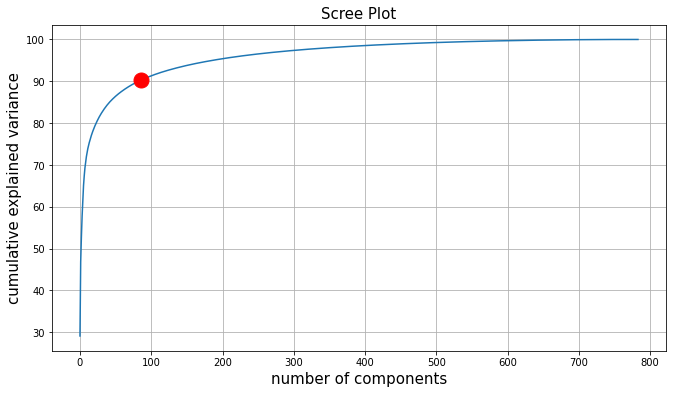

In [6]:
#Decideing number of components from variance
variance = pca.explained_variance_ratio_.cumsum()
#for i in range(0,len(variance)):
#  if(variance[i] > 0.90):
#    print(i)
#    break;

print("Variance explained by 85th Components:", variance[85]*100)

plt.figure(figsize = (11,6))
plt.plot(np.arange(0, 784), variance*100)
plt.plot(85, variance[85]*100, 'ro', ms = 15)
plt.xlabel('number of components', fontsize = 15)
plt.ylabel('cumulative explained variance', fontsize = 15)
plt.title('Scree Plot', fontsize = 15)
plt.grid(True)

In [0]:
#Function for SVM
from sklearn import svm
import time
def SVM(c):
  svc = svm.SVC(kernel='rbf', C = c)
  start = time.time()
  svc.fit(train_x_transformed[:,:85], y_train)
  end = time.time()
  train_time = end - start
  start = time.time()
  y_pred = svc.predict(val_x_transformed[:,:85])
  end = time.time()
  test_time = end - start
  accuracy = accuracy_score(y_val, y_pred)
  print(accuracy)
  print(train_time, ' ', test_time)
  return (accuracy,(train_time, test_time))

In [0]:
#Function for finding Accuracy Scores
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

def metrics_scores(y_val, y_pred):
  yhat_classes = y_pred
  #yhat_probs = svc.predict_proba(X_val_transformed[:,:19])

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_val, yhat_classes)
  print('Accuracy: %f' % accuracy)

  # precision tp / (tp + fp)
  precision = precision_score(y_val, yhat_classes, average = 'micro')
  print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
  recall = recall_score(y_val, yhat_classes, average = 'micro')
  print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_val, yhat_classes, average = 'micro')
  print('F1 score: %f' % f1)

  # kappa
  #kappa = cohen_kappa_score(y_val, yhat_classes)
  #print('Cohens kappa: %f' % kappa)

  # ROC AUC
  #auc = roc_auc_score(y_val, yhat_probs, multi_class = 'ovr')
  #print('ROC AUC: %f' % auc)

  matrix = multilabel_confusion_matrix(y_val, yhat_classes, labels = [0,1,2,3,4])
  print(matrix)

  #Reference:
  #https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [0]:
#Function for Plotting AUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
n_classes = 5

def roc_plot(y_val, y_pred):
  y_val = label_binarize(y_val, classes = [0,1,2,3,4])
  y_pred = label_binarize(y_pred, classes = [0,1,2,3,4])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  import itertools
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize = (10,6))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, linewidth=4,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

In [10]:
accuracy_list = []
train_time_list = []
test_time_list = []

c = [1,2,3,4,5,6,7,8,9,10]

for i in c:
  (a,t) = SVM(i)
  accuracy_list.append(a)
  train_time_list.append(t[0])
  train_time_list.append(t[1])

0.8833333333333333
118.66015338897705   16.840491771697998
0.8876666666666667
110.40699434280396   15.84793996810913
0.8911666666666667
109.84031796455383   15.192175149917603
0.893
109.80285263061523   15.125280380249023
0.8943333333333333
111.64872026443481   14.803386688232422
0.895
112.96194291114807   14.659424543380737
0.8955
114.16180682182312   14.416593074798584
0.897
117.80842781066895   14.569004774093628
0.8965
120.72806310653687   14.690544843673706
0.8968333333333334
121.70759963989258   14.30504322052002


In [11]:
accuracy_list = []
train_time_list = []
test_time_list = []

c = [10,20,30,40,50,60,70,80,90,100]

for i in c:
  (a,t) = SVM(i)
  accuracy_list.append(a)
  train_time_list.append(t[0])
  train_time_list.append(t[1])

0.8968333333333334
119.52126479148865   13.83258867263794
0.898
143.53914666175842   13.53851580619812
0.8958333333333334
168.57454633712769   13.51935625076294
0.8948333333333334
186.37018585205078   13.750890254974365
0.8948333333333334
197.56211733818054   13.187148571014404
0.8936666666666667
204.6416962146759   13.266111135482788
0.8928333333333334
210.97321391105652   13.352272272109985
0.8923333333333333
220.89573526382446   13.606130838394165
0.8911666666666667
223.87994813919067   13.506962299346924
0.8906666666666667
227.82587099075317   13.315249919891357


In [12]:
accuracy_list1 = []
train_time_list1 = []
test_time_list1 = []

c = [11,12,13,14,15,16,17,18,19,20]

for i in c:
  (a,t) = SVM(i)
  accuracy_list1.append(a)
  train_time_list1.append(t[0])
  train_time_list1.append(t[1])

0.8963333333333333
122.16346287727356   14.306559085845947
0.8968333333333334
129.10687446594238   13.79617714881897
0.8963333333333333
130.63729119300842   13.781571865081787
0.8973333333333333
132.74026918411255   13.700480699539185
0.8975
140.22678136825562   13.888767004013062
0.8976666666666666
143.44633722305298   13.613953590393066
0.8983333333333333
142.33355808258057   13.63148307800293
0.8978333333333334
135.87380027770996   13.355126857757568
0.8978333333333334
137.9281027317047   13.400207996368408
0.898
140.07122778892517   13.265637397766113


0.8983333333333333
131.00653791427612   13.313571214675903
Accuracy for training data:  0.9626111111111111
Accuracy: 0.898333
Precision: 0.898333
Recall: 0.898333
F1 score: 0.898333
[[[4741   69]
  [  46 1144]]

 [[4611  159]
  [ 137 1093]]

 [[4653  165]
  [ 182 1000]]

 [[4686  139]
  [ 166 1009]]

 [[4699   78]
  [  79 1144]]]


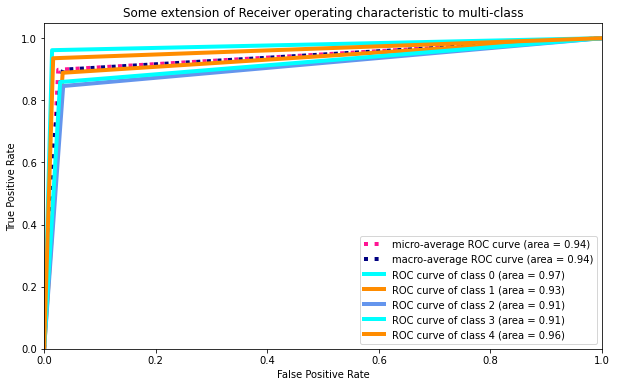

In [13]:
#Accuracy score and ROC plot of best Parameter
svc = svm.SVC(kernel='rbf', C = 17)
start = time.time()
svc.fit(train_x_transformed[:,:85], y_train)
end = time.time()
train_time = end - start
start = time.time()
y_pred = svc.predict(val_x_transformed[:,:85])
end = time.time()
test_time = end - start
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(train_time, ' ', test_time)
y_train_pred = svc.predict(train_x_transformed[:,:85])
accuracy_train = accuracy_score(y_train, y_train_pred)
print('Accuracy for training data: ', accuracy_train)
metrics_scores(y_val,y_pred)
roc_plot(y_val, y_pred)

0.8833333333333333
126.03567218780518   18.529507160186768
Accuracy for training data:  0.9
Accuracy: 0.883333
Precision: 0.883333
Recall: 0.883333
F1 score: 0.883333
[[[4722   88]
  [  59 1131]]

 [[4612  158]
  [ 180 1050]]

 [[4613  205]
  [ 202  980]]

 [[4662  163]
  [ 179  996]]

 [[4691   86]
  [  80 1143]]]


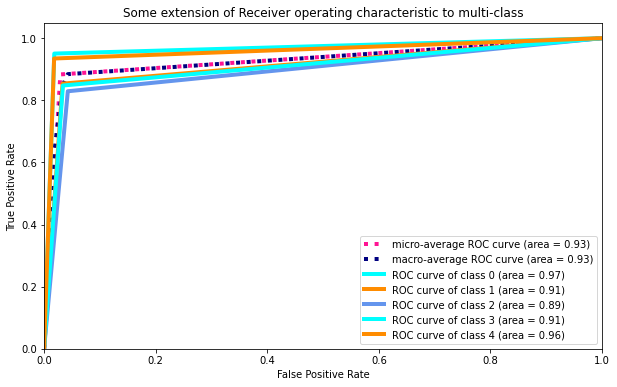

In [14]:
#Accuracy score and ROC plot C=1
svc = svm.SVC(kernel='rbf', C = 1)
start = time.time()
svc.fit(train_x_transformed[:,:85], y_train)
end = time.time()
train_time = end - start
start = time.time()
y_pred = svc.predict(val_x_transformed[:,:85])
end = time.time()
test_time = end - start
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(train_time, ' ', test_time)
y_train_pred = svc.predict(train_x_transformed[:,:85])
accuracy_train = accuracy_score(y_train, y_train_pred)
print('Accuracy for training data: ', accuracy_train)
metrics_scores(y_val,y_pred)
roc_plot(y_val, y_pred)

0.8943333333333333
109.45182633399963   14.762230157852173
Accuracy for training data:  0.9350925925925926
Accuracy: 0.894333
Precision: 0.894333
Recall: 0.894333
F1 score: 0.894333
[[[4730   80]
  [  52 1138]]

 [[4614  156]
  [ 153 1077]]

 [[4648  170]
  [ 196  986]]

 [[4677  148]
  [ 158 1017]]

 [[4697   80]
  [  75 1148]]]


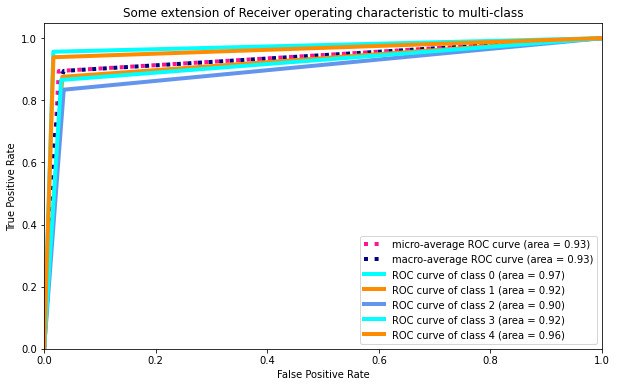

In [15]:
#Accuracy score and ROC plot C=5
svc = svm.SVC(kernel='rbf', C = 5)
start = time.time()
svc.fit(train_x_transformed[:,:85], y_train)
end = time.time()
train_time = end - start
start = time.time()
y_pred = svc.predict(val_x_transformed[:,:85])
end = time.time()
test_time = end - start
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(train_time, ' ', test_time)
y_train_pred = svc.predict(train_x_transformed[:,:85])
accuracy_train = accuracy_score(y_train, y_train_pred)
print('Accuracy for training data: ', accuracy_train)
metrics_scores(y_val,y_pred)
roc_plot(y_val, y_pred)

0.8968333333333334
117.4008321762085   13.782493829727173
Accuracy for training data:  0.9508518518518518
Accuracy: 0.896833
Precision: 0.896833
Recall: 0.896833
F1 score: 0.896833
[[[4738   72]
  [  46 1144]]

 [[4614  156]
  [ 145 1085]]

 [[4650  168]
  [ 187  995]]

 [[4678  147]
  [ 162 1013]]

 [[4701   76]
  [  79 1144]]]


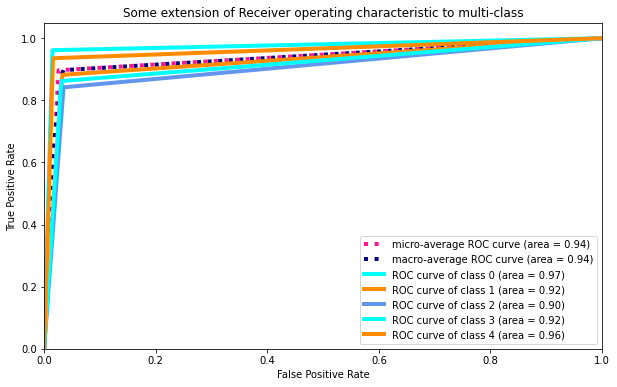

In [16]:
#Accuracy score and ROC plot C=10
svc = svm.SVC(kernel='rbf', C = 10)
start = time.time()
svc.fit(train_x_transformed[:,:85], y_train)
end = time.time()
train_time = end - start
start = time.time()
y_pred = svc.predict(val_x_transformed[:,:85])
end = time.time()
test_time = end - start
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(train_time, ' ', test_time)
y_train_pred = svc.predict(train_x_transformed[:,:85])
accuracy_train = accuracy_score(y_train, y_train_pred)
print('Accuracy for training data: ', accuracy_train)
metrics_scores(y_val,y_pred)
roc_plot(y_val, y_pred)

0.8975
126.20506262779236   13.458404541015625
Accuracy for training data:  0.96
Accuracy: 0.897500
Precision: 0.897500
Recall: 0.897500
F1 score: 0.897500
[[[4742   68]
  [  48 1142]]

 [[4610  160]
  [ 142 1088]]

 [[4647  171]
  [ 183  999]]

 [[4687  138]
  [ 166 1009]]

 [[4699   78]
  [  76 1147]]]


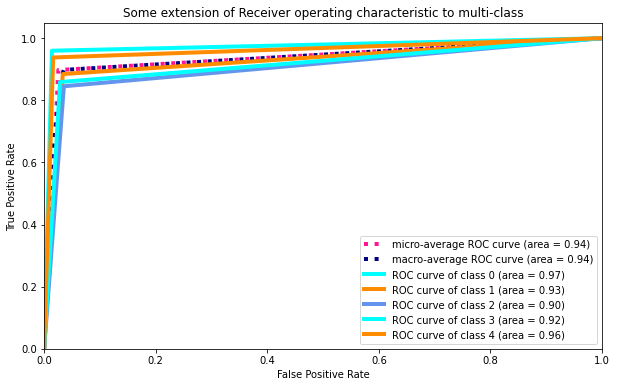

In [20]:
#Accuracy score and ROC plot C=15
svc = svm.SVC(kernel='rbf', C = 15)
start = time.time()
svc.fit(train_x_transformed[:,:85], y_train)
end = time.time()
train_time = end - start
start = time.time()
y_pred = svc.predict(val_x_transformed[:,:85])
end = time.time()
test_time = end - start
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(train_time, ' ', test_time)
y_train_pred = svc.predict(train_x_transformed[:,:85])
accuracy_train = accuracy_score(y_train, y_train_pred)
print('Accuracy for training data: ', accuracy_train)
metrics_scores(y_val,y_pred)
roc_plot(y_val, y_pred)

0.898
139.43427157402039   13.388598680496216
Accuracy for training data:  0.9660555555555556
Accuracy: 0.898000
Precision: 0.898000
Recall: 0.898000
F1 score: 0.898000
[[[4743   67]
  [  46 1144]]

 [[4608  162]
  [ 136 1094]]

 [[4654  164]
  [ 187  995]]

 [[4684  141]
  [ 164 1011]]

 [[4699   78]
  [  79 1144]]]


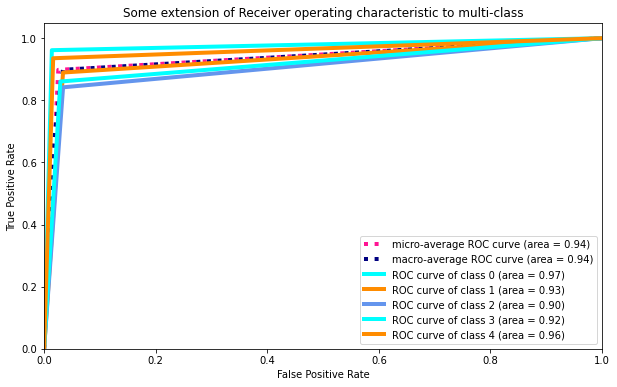

In [21]:
#Accuracy score and ROC plot C=20
svc = svm.SVC(kernel='rbf', C = 20)
start = time.time()
svc.fit(train_x_transformed[:,:85], y_train)
end = time.time()
train_time = end - start
start = time.time()
y_pred = svc.predict(val_x_transformed[:,:85])
end = time.time()
test_time = end - start
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(train_time, ' ', test_time)
y_train_pred = svc.predict(train_x_transformed[:,:85])
accuracy_train = accuracy_score(y_train, y_train_pred)
print('Accuracy for training data: ', accuracy_train)
metrics_scores(y_val,y_pred)
roc_plot(y_val, y_pred)

0.8958333333333334
162.40089058876038   13.053820848464966
Accuracy for training data:  0.9738518518518519
Accuracy: 0.895833
Precision: 0.895833
Recall: 0.895833
F1 score: 0.895833
[[[4737   73]
  [  49 1141]]

 [[4598  172]
  [ 149 1081]]

 [[4654  164]
  [ 189  993]]

 [[4685  140]
  [ 161 1014]]

 [[4701   76]
  [  77 1146]]]


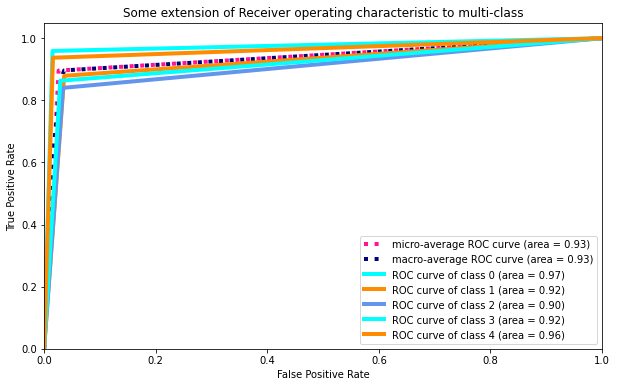

In [22]:
#Accuracy score and ROC plot C=30
svc = svm.SVC(kernel='rbf', C = 30)
start = time.time()
svc.fit(train_x_transformed[:,:85], y_train)
end = time.time()
train_time = end - start
start = time.time()
y_pred = svc.predict(val_x_transformed[:,:85])
end = time.time()
test_time = end - start
accuracy = accuracy_score(y_val, y_pred)
print(accuracy)
print(train_time, ' ', test_time)
y_train_pred = svc.predict(train_x_transformed[:,:85])
accuracy_train = accuracy_score(y_train, y_train_pred)
print('Accuracy for training data: ', accuracy_train)
metrics_scores(y_val,y_pred)
roc_plot(y_val, y_pred)